<center> <a href="https://githubtocolab.com/neurohari/NeuralDecoders/blob/main/notebooks/behavior-trained-decoder-of-spikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> </center>

# Decoding spikes from neural data + behavior 

## 1 Introduction

### 1.1 Background

 * Dr. Hari Teja Kalidindi
 * Dr. Bhargav Nallapu

Neural Latents Benchmark '21 (NLB'21) is a benchmark suite aimed at standardizing evaluation of latent variable models of neural spiking activity spanning a variety of tasks and brain areas. The primary objective of the challenge is to infer the firing rates of a set of held-out neurons given the spiking activity of held-in neurons, a procedure called co-smoothing.

The benchmark suite features several datasets from experiments spanning a range of behaviors and brain regions, but they are all provided in the standard Neurodata Without Borders format and available on [DANDI](https://dandiarchive.org). The benchmark challenge itself is hosted on the platform [EvalAI](https://eval.ai), where model predictions can be submitted and automatically evaluated on private evaluation data.

To facilitate participation in the competition, we provide the code package [`nlb_tools`](https://github.com/neurallatents/nlb_tools), which has functions for data preprocessing and submission preparation.

### 1.2 Notebook Overview
This notebook will cover all of the steps in participating in NLB'21, including:
1. **Dataset download** - getting dataset files from DANDI on to your machine
2. **Data loading and preprocessing** - using `nlb_tools` to extract the data we expect you to model
3. **Modeling neural data** - in this notebook, demonstrating one potential modeling approach using an RNN
4. **Submitting and evaluating model predictions** - packaging predictions for submission to EvalAI or local evaluation

<center> <img src="https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/img/tutorial_diagram_main.png?raw=true" width="480" /> </center>

### 1.2 Setup

First, we need to install and import the packages we need for this notebook.

In [2]:
# Uncomment the ones you need:

# nlb_tools
!pip install git+https://github.com/neurallatents/nlb_tools.git 

# PyTorch (for modeling)
!pip install torch

# DANDI CLI tool (optional, can use website instead)
!pip install dandi

# EvalAI-CLI (optional, can use website instead)
# !pip install evalai

## 2 Data Preparation

### 2.1 Dataset Download

<center> <img src="https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/img/tutorial_diagram_main_download.png?raw=true" width="800" /> </center>

The datasets are available on the platform DANDI. They can be downloaded directly from the website or by using the DANDI CLI tool, as shown below. For this notebook, we will be using the MC_Maze_Large dataset, which is available from [here](https://dandiarchive.org/dandiset/000138). Links to the other datasets can be found on [our website](https://neurallatents.github.io/datasets).

In [1]:
!dandi download https://dandiarchive.org/dandiset/000138

PATH                                                              SIZE      DONE            DONE% CHECKSUM STATUS          MESSAGE   
dandiset.yaml                                                                                              done            updated   
sub-Jenkins\sub-Jenkins_ses-large_desc-test_ecephys.nwb           802.4 kB  802.4 kB         100%    ok    done                      
sub-Jenkins\sub-Jenkins_ses-large_desc-train_behavior+ecephys.nwb 148.6 MB  148.6 MB         100%    ok    done                      
Summary:                                                          149.4 MB  149.4 MB                       3 done          1 updated 
                                                                            100.00%                                                  


2022-03-22 17:59:35,258 [ WARNING] A newer version (0.37.0) of dandi/dandi-cli is available. You are using 0.35.0
2022-03-22 18:00:49,704 [    INFO] Logs saved in C:\Users\kalidindi\AppData\Local\dandi\dandi-cli\Logs\20220322165934Z-21668.log


The above line will download two files into the folder `./000138/sub-Jenkins/`. Next, we'll get the path of the downloaded files and list them.

In [1]:
import os
curr_path = os.getcwd()
fpath = curr_path + '/datasets/000138/sub-Jenkins/'
os.listdir(fpath) 

['sub-Jenkins_ses-large_desc-test_ecephys.nwb',
 'sub-Jenkins_ses-large_desc-train_behavior+ecephys.nwb']

The file with 'desc-train' in its name is for training, while the file with 'desc-test' in its name is for final model evaluation. As we take a look at the data, we will see the differences between these two files.

### 2.2 Dataset Loading

<center> <img src="https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/img/tutorial_diagram_main_dataload.png?raw=true" width="800" /> </center>

To get the NWB data into Python, we provide the `NWBDataset` class, which can load from the dataset files and perform simple preprocessing operations. To load a dataset, you instantiate an instance of NWBDataset and provide the path to the files.

In [2]:
from nlb_tools.nwb_interface import NWBDataset

dataset = NWBDataset(fpath=fpath) 

### 2.3 Data Format

The loaded data are primarily stored in two pandas DataFrames: `NWBDataset.data` and `NWBDataset.trial_info`.

#### `NWBDataset.data`
`NWBDataset.data` contains the continuous recorded data, like spike counts and kinematics. Each row consists of measurements taken at a particular timestep. Most importantly, spiking data from held-in units are labeled `spikes` and data from held-out units is labeled `heldout_spikes`.

In the training data, all fields are available:

In [3]:
dataset.data.shape

(1565021, 170)

In [4]:
dataset.data.iloc[100000:100100]


signal_type            cursor_pos           eye_pos        hand_pos  \
channel                         x         y       x     y         x   
clock_time                                                            
0 days 00:01:40         -5.200000  3.300000     0.6   1.1 -5.195095   
0 days 00:01:40.001000  -5.199120  3.299442     2.5   0.6 -5.196711   
0 days 00:01:40.002000  -5.198598  3.299110     2.5   0.4 -5.198551   
0 days 00:01:40.003000  -5.198598  3.299110     2.7   0.5 -5.200457   
0 days 00:01:40.004000  -5.199120  3.299442     2.8   0.8 -5.202659   
...                           ...       ...     ...   ...       ...   
0 days 00:01:40.095000  -5.200000  3.300000     1.6   8.8 -5.239548   
0 days 00:01:40.096000  -5.193734  3.308271     1.7   9.1 -5.240553   
0 days 00:01:40.097000  -5.188833  3.311073     0.0  10.0 -5.241476   
0 days 00:01:40.098000  -5.187298  3.309505     0.3   9.7 -5.242439   
0 days 00:01:40.099000  -5.190729  3.305204     0.2   9.7 -5.243523   

signal_type                        hand_vel           heldout_spikes       \
channel                         y         x         y           1031 1051   
clock_time                                                                  
0 days 00:01:40        -31.606258 -1.481366  0.261386            0.0  0.0   
0 days 00:01:40.001000 -31.605926 -1.727835  0.317635            0.0  0.0   
0 days 00:01:40.002000 -31.605623 -1.873343  0.342863            0.0  0.0   
0 days 00:01:40.003000 -31.605240 -2.053902  0.334682            0.0  0.0   
0 days 00:01:40.004000 -31.604953 -2.238392  0.280908            0.0  0.0   
...                           ...       ...       ...            ...  ...   
0 days 00:01:40.095000 -31.618091 -1.010222 -1.636778            0.0  0.0   
0 days 00:01:40.096000 -31.619778 -0.964223 -1.878082            0.0  0.0   
0 days 00:01:40.097000 -31.621848 -0.942786 -2.159794            0.0  0.0   
0 days 00:01:40.098000 -31.624097 -1.023439 -2.277696            0.0  0.0   
0 days 00:01:40.099000 -31.626403 -0.917548 -2.321146            0.0  0.0   

signal_type             ... spikes                                          \
channel                 ...   2741 2743 2761 2771 2781 2791 2801 2881 2941   
clock_time              ...                                                  
0 days 00:01:40         ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:01:40.001000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:01:40.002000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:01:40.003000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:01:40.004000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                     ...    ...  ...  ...  ...  ...  ...  ...  ...  ...   
0 days 00:01:40.095000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:01:40.096000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:01:40.097000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:01:40.098000  ...    0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0   
0 days 00:01:40.099000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

signal_type                  
channel                2951  
clock_time                   
0 days 00:01:40         0.0  
0 days 00:01:40.001000  0.0  
0 days 00:01:40.002000  0.0  
0 days 00:01:40.003000  0.0  
0 days 00:01:40.004000  0.0  
...                     ...  
0 days 00:01:40.095000  0.0  
0 days 00:01:40.096000  0.0  
0 days 00:01:40.097000  0.0  
0 days 00:01:40.098000  0.0  
0 days 00:01:40.099000  0.0  

[100 rows x 170 columns]

In the test data, only held-in spikes are available, while other data is concealed with NaNs:

In [5]:
dataset.data.iloc[1000:1100]

signal_type            cursor_pos     eye_pos     hand_pos     hand_vel      \
channel                         x   y       x   y        x   y        x   y   
clock_time                                                                    
0 days 00:00:01               NaN NaN     NaN NaN      NaN NaN      NaN NaN   
0 days 00:00:01.001000        NaN NaN     NaN NaN      NaN NaN      NaN NaN   
0 days 00:00:01.002000        NaN NaN     NaN NaN      NaN NaN      NaN NaN   
0 days 00:00:01.003000        NaN NaN     NaN NaN      NaN NaN      NaN NaN   
0 days 00:00:01.004000        NaN NaN     NaN NaN      NaN NaN      NaN NaN   
...                           ...  ..     ...  ..      ...  ..      ...  ..   
0 days 00:00:01.095000        NaN NaN     NaN NaN      NaN NaN      NaN NaN   
0 days 00:00:01.096000        NaN NaN     NaN NaN      NaN NaN      NaN NaN   
0 days 00:00:01.097000        NaN NaN     NaN NaN      NaN NaN      NaN NaN   
0 days 00:00:01.098000        NaN NaN     NaN NaN      NaN NaN      NaN NaN   
0 days 00:00:01.099000        NaN NaN     NaN NaN      NaN NaN      NaN NaN   

signal_type            heldout_spikes       ... spikes                      \
channel                          1031 1051  ...   2741 2743 2761 2771 2781   
clock_time                                  ...                              
0 days 00:00:01                   NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:01.001000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:01.002000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:01.003000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:01.004000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
...                               ...  ...  ...    ...  ...  ...  ...  ...   
0 days 00:00:01.095000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:01.096000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:01.097000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:01.098000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:01.099000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   

signal_type                                      
channel                2791 2801 2881 2941 2951  
clock_time                                       
0 days 00:00:01         0.0  0.0  0.0  0.0  0.0  
0 days 00:00:01.001000  0.0  0.0  1.0  0.0  0.0  
0 days 00:00:01.002000  0.0  0.0  0.0  0.0  0.0  
0 days 00:00:01.003000  0.0  0.0  0.0  0.0  0.0  
0 days 00:00:01.004000  0.0  0.0  0.0  0.0  0.0  
...                     ...  ...  ...  ...  ...  
0 days 00:00:01.095000  0.0  0.0  0.0  0.0  0.0  
0 days 00:00:01.096000  0.0  0.0  0.0  0.0  0.0  
0 days 00:00:01.097000  0.0  0.0  0.0  0.0  0.0  
0 days 00:00:01.098000  0.0  0.0  0.0  0.0  0.0  
0 days 00:00:01.099000  0.0  0.0  0.0  0.0  0.0  

[100 rows x 170 columns]


#### `NWBDataset.trial_info`
Each row of `trial_info` contains information about a particular experimental trial, such as when it begins and ends. As with the `NWBDataset.data`, almost all information is concealed in the test data. The field `split`, common to all of our provided datasets, indicates what data split a trial belongs to (explained in more detail in Section 2.4).

In [6]:
dataset.trial_info

,trial_id,start_time,end_time,move_onset_time,split,trial_type,trial_version,maze_id,success,target_on_time,go_cue_time,rt,delay,num_targets,target_pos,num_barriers,barrier_pos,active_target
0,0,0 days 00:00:00,0 days 00:00:00.700000,0 days 00:00:00.250000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0 days 00:00:00.800000,0 days 00:00:01.500000,0 days 00:00:01.050000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0 days 00:00:01.600000,0 days 00:00:02.300000,0 days 00:00:01.850000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0 days 00:00:02.400000,0 days 00:00:03.100000,0 days 00:00:02.650000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0 days 00:00:03.200000,0 days 00:00:03.900000,0 days 00:00:03.450000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,0 days 00:25:49.600000,0 days 00:25:52.636000,0 days 00:25:51.501000,train,8.0,1.0,38.0,True,0 days 00:25:50.405000,0 days 00:25:51.153000,348.0,748.0,1.0,"[[-105, 76]]",9.0,"[[74, -102, 11, 53], [86, -44, 14, 11], [103, ...",0.0
596,596,0 days 00:25:52.700000,0 days 00:25:55.746000,0 days 00:25:54.595000,train,11.0,2.0,80.0,True,0 days 00:25:53.467000,0 days 00:25:54.116000,479.0,649.0,3.0,"[[123, -81], [-130, -13], [123, 71]]",8.0,"[[-65, -15, 14, 51], [-79, -55, 55, 6], [-103,...",2.0
597,597,0 days 00:25:55.800000,0 days 00:25:58.801000,0 days 00:25:57.701000,val,7.0,2.0,37.0,True,0 days 00:25:56.545000,0 days 00:25:57.410000,291.0,865.0,3.0,"[[124, -79], [103, 83], [-105, 76]]",9.0,"[[74, -102, 11, 53], [86, -44, 14, 11], [103, ...",1.0
598,598,0 days 00:25:58.900000,0 days 00:26:01.956000,0 days 00:26:00.777000,train,7.0,1.0,37.0,True,0 days 00:25:59.613000,0 days 00:26:00.479000,298.0,866.0,1.0,"[[103, 83]]",9.0,"[[74, -102, 11, 53], [86, -44, 14, 11], [103, ...",0.0


### 2.4 Data Splits

<center> <img src="https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/img/data_splits.png?raw=true" width="480" /> </center>

The dataset is divided into train, val, and test splits. The train and val splits are contained within the training data file, while the test split is entirely in the test data file. This means that all data fields are available in the train and val splits, but only held-in data is available in the test split. The NLB'21 challenge has two phases based on these splits:
1. In the Validation Phase, models will be evaluated on their val split predictions. This phase is offered for sanity checking results and building familiarity with the EvalAI platform.
2. In the Test Phase, models will be evaluated on their test split predictions. This is the phase that is displayed on the public leaderboard. In this phase, the val split does not strictly need to be used for model validation, despite its name.

In this notebook, we will prepare a submission for the Validation Phase, though the code can be easily modified for the Test Phase.

### 2.5 Data Extraction

#### 2.5.1 Resampling


<center> <img src="https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/img/tutorial_diagram_main_resample.png?raw=true" width="800" /> </center>

The raw data is at 1 ms resolution, but the NLB'21 challenge expects submissions to be at 5 ms resolution, so we will resample the data before doing any other processing.

In [8]:
print(f'Data shape: {dataset.data.shape}')
print(f'Bin width: {dataset.bin_width} ms')
dataset.resample(5)
print(f'Resampled data shape: {dataset.data.shape}')
print(f'Resampled bin width: {dataset.bin_width} ms')

Dataset already at 5 ms resolution, skipping resampling...


Data shape: (313005, 170)
Bin width: 5 ms
Resampled data shape: (313005, 170)
Resampled bin width: 5 ms


#### 2.5.2 Trial Alignment

<center> <img src="https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/img/tutorial_diagram_main_alignment.png?raw=true" width="800" /> </center>

To simplify data preparation, we abstract other formatting steps into the functions `make_train_input_tensors` and `make_eval_input_tensors`. These wrapper functions format the raw data into tensors to be used for model training and evaluation. The primary processing performed by the functions is trial alignment.

Trial alignment involves choosing a particular trial event, such as a go cue, and taking a fixed window of data around each occurrence of that event. For all of the datasets in NLB'21, we have chosen trial alignments based on the experimental design and past analyses on the data. For the MC_Maze_Large dataset, the selected trial alignment is 250 ms before to 450 ms after movement onset. Our wrapper functions will apply this alignment when given the correct dataset name.

In [9]:
from nlb_tools.make_tensors import make_train_input_tensors, make_eval_input_tensors

`make_train_input_tensors` extracts the data available for model training. 

In [11]:
train_dict = make_train_input_tensors(dataset=dataset, 
                                      dataset_name='mc_maze_large', 
                                      trial_split='train', # trial_split=['train', 'val'], for Test phase
                                      save_file=False, 
                                      include_behavior=True,
                                      include_forward_pred=True)

`make_eval_input_tensors` extracts the data used to evaluate the model. 

In [12]:
eval_dict = make_eval_input_tensors(dataset=dataset,
                                    dataset_name='mc_maze_large',
                                    trial_split='val', # trial_split='test', for Test phase
                                    save_file=False)

<center> <img src="https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/img/tutorial_diagram_main_naming.png?raw=true" width="600" /> </center>

Both `make_train_input_tensors` and `make_eval_input_tensors` return dictionaries of tensors. 

The training dictionary contains:
- train_spikes_heldin - spiking activity of held-in units on training trials 
- train_spikes_heldout - spiking activity of held-out units on training trials
- train_spikes_heldin_forward - spiking activity of held-in units immediately after the trial period
- train_spikes_heldout_forward - spiking activity of held-iout units immediately after the trial period

The four different sets of data are visualized in the above figure. Each set of data is a 3D array with dimensions Trial x Time x Channel. 

<!---The tensor naming conventions are fairly straightforward. The tensors labeled 'heldin' contain spiking activity from held-in units. The tensors labeled 'heldout' contain spiking activity from held-out units. The tensors labeled 'forward' contain additional spiking activity occurring after each aligned trial window. All tensors have dimensions Batch x Time x Channel. --->

In [13]:
print(train_dict.keys())

dict_keys(['train_spikes_heldin', 'train_spikes_heldout', 'train_behavior', 'train_spikes_heldin_forward', 'train_spikes_heldout_forward'])


In [14]:
print(train_dict['train_spikes_heldin'].shape)
print(train_dict['train_spikes_heldout'].shape)
print(train_dict['train_behavior'].shape)
print(train_dict['train_spikes_heldin_forward'].shape)
print(train_dict['train_spikes_heldout_forward'].shape)

(375, 140, 122)
(375, 140, 40)
(375, 140, 2)
(375, 40, 122)
(375, 40, 40)


The shapes above indicate that there are 375 training trials, 140 time bins during the trial, 40 time bins after the trial, 122 held-in units, and 40 held-out units in this dataset.

Next, we look at the data used for evaluation.

In [15]:
print(eval_dict.keys())

dict_keys(['eval_spikes_heldin', 'eval_spikes_heldout'])


In [16]:
print(eval_dict['eval_spikes_heldin'].shape)

(125, 140, 122)


The output tensors of `make_eval_input_tensors` follow the same dimension ordering and naming conventions as those in `train_dict`. The only tensor that will always be returned in `eval_dict` is `'eval_spikes_heldin'`, as that is the only data available in the test split.

If you are using a language other than Python for your model, you will want to save these tensors as HDF5 files by changing the `save_file=False` lines in the above examples to `save_file=True`. The HDF5 files will have the same key-value pairs as the dicts and can be loaded into other programs like [MATLAB](https://www.mathworks.com/help/matlab/import_export/importing-hierarchical-data-format-hdf5-files.html) or [R](https://www.bioconductor.org/packages/devel/bioc/vignettes/rhdf5/inst/doc/rhdf5.html) scripts.

## 3 Modeling


<center> <img src="https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/img/tutorial_diagram_main_modeling.png?raw=true" width="480" /> </center>


Now, we will apply a simple RNN to the challenge. Our code for training the model is available [here](https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/train.py), but we will load a pre-trained model instead of training here due to time constraints.

### 3.1 Model Definition

We define a class that models the data with an RNN and uses an exponential mapping to firing rates.

In [29]:
import os, gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from datetime import datetime

from nlb_tools.nwb_interface import NWBDataset
from nlb_tools.make_tensors import make_train_input_tensors, make_eval_input_tensors
from nlb_tools.evaluation import evaluate

SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

def get_data(dataset_name, phase='test', bin_size=5):
    """Function that extracts and formats data for training model"""
    curr_path = os.getcwd()
    fpath = curr_path + '/datasets/000138/sub-Jenkins/'
    dataset = NWBDataset(fpath, 
        skip_fields=['cursor_pos', 'eye_pos', 'cursor_vel', 'eye_vel', 'hand_pos'])
    dataset.resample(1)
    train_split = ['train', 'val'] if phase == 'test' else 'train'
    eval_split = phase
    train_dict = make_train_input_tensors(dataset, dataset_name, train_split, save_file=False, include_forward_pred=True)
    eval_dict = make_eval_input_tensors(dataset, dataset_name, eval_split, save_file=False)
    training_input = np.concatenate([
        train_dict['train_spikes_heldin'],
        np.zeros(train_dict['train_spikes_heldin_forward'].shape),
    ], axis=1)
    training_output = np.concatenate([
        np.concatenate([
            train_dict['train_spikes_heldin'],
            train_dict['train_spikes_heldin_forward'],
        ], axis=1),
        np.concatenate([
            train_dict['train_spikes_heldout'],
            train_dict['train_spikes_heldout_forward'],
        ], axis=1),
    ], axis=2)
    eval_input = np.concatenate([
        eval_dict['eval_spikes_heldin'],
        np.zeros((
            eval_dict['eval_spikes_heldin'].shape[0],
            train_dict['train_spikes_heldin_forward'].shape[1],
            eval_dict['eval_spikes_heldin'].shape[2]
        )),
    ], axis=1)
    del dataset
    return training_input, training_output, eval_input

class NLBRNN(torch.nn.Module):
    """Simple RNN to model spiking data"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(NLBRNN, self).__init__()
        self.rnn = torch.nn.GRU(input_size=input_dim,
                                    hidden_size=hidden_dim,
                                    num_layers=num_layers,
                                    batch_first=True,
                                    bidirectional=False,
                                    **factory_kwargs)
        self.transform = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, X):
        output, hidden = self.rnn(X)
        output = self.transform(output)
        return torch.exp(output)

class NLBRunner:
    """Class that handles training NLBRNN"""
    def __init__(self, model_init, model_cfg, data, train_cfg, use_gpu=False, num_gpus=1):
        self.model = model_init(**model_cfg)
        self.data = data
        self.cd_ratio = train_cfg.get('cd_ratio', 0.2)
        self.optimizer = torch.optim.Adam(self.model.parameters(), 
                                          lr=train_cfg.get('lr', 1e-3), 
                                          weight_decay=train_cfg.get('alpha', 0.0))
    
    
    def train_epoch(self):
        """Trains model for one epoch. 
        This simple script does not support splitting training samples into batches.
        """
        self.model.train()
        self.optimizer.zero_grad()
        # create mask for coordinated dropout
        train_input, train_output, val_input, val_output, *_ = self.data

        # mask inputs
        masked_train_input = train_input.clone()

        train_predictions = self.model(masked_train_input)
        # learn only from masked inputs
        loss = torch.nn.functional.poisson_nll_loss(train_predictions, train_output, log_input=False)
        loss.backward()
        self.optimizer.step()
        # get validation score
        train_res, train_output = self.score(train_input, train_output, prefix='train')
        val_res, val_output = self.score(val_input, val_output, prefix='val')
        res = train_res.copy()
        res.update(val_res)
        return res, (train_output, val_output)
    
    def score(self, input, output, prefix='val'):
        """Evaluates model performance on given data"""
        self.model.eval()
        predictions = self.model(input)
        self.model.train()
        loss = torch.nn.functional.poisson_nll_loss(predictions, output, log_input=False)
        num_heldout = output.shape[2] - input.shape[2]
        cosmooth_loss = torch.nn.functional.poisson_nll_loss(
            predictions[:, :, -num_heldout:], output[:, :, -num_heldout:], log_input=False)
        return {f'{prefix}_nll': loss.item(), f'{prefix}_cosmooth_nll': cosmooth_loss.item()}, predictions

    def train(self, n_iter=1000, patience=200, save_path=None, verbose=False, log_frequency=50):
        """Trains model for given number of iterations with early stopping"""
        train_log = []
        best_score = 1e8
        last_improv = -1
        for i in range(n_iter):
            res, output = self.train_epoch()
            res['iter'] = i
            train_log.append(res)
            if verbose:
                if (i % log_frequency) == 0:
                    print(res)
            if res['val_nll'] < best_score:
                best_score = res['val_nll']
                last_improv = i
                data = res.copy()
                if save_path is not None:
                    self.save_checkpoint(save_path, data)
            if (i - last_improv) > patience:
                break
        return train_log
    
    def save_checkpoint(self, file_path, data):
        default_ckpt = {
            "state_dict": self.model.state_dict(),
            "optim_state": self.optimizer.state_dict(),
        }
        assert "state_dict" not in data
        assert "optim_state" not in data
        default_ckpt.update(data)
        torch.save(default_ckpt, file_path)
        
# Run parameters
dataset_name = 'mc_maze_large'
phase = 'val'
bin_size = 5

# Extract data
training_input, training_output, eval_input = get_data(dataset_name, phase, bin_size)

# Train/val split and convert to Torch tensors
num_train = int(round(training_input.shape[0] * 0.75))
train_input = torch.Tensor(training_input[:num_train])
train_output = torch.Tensor(training_output[:num_train])
val_input = torch.Tensor(training_input[num_train:])
val_output = torch.Tensor(training_output[num_train:])
eval_input = torch.Tensor(eval_input)


# Model hyperparameters
DROPOUT = 0.46
L2_WEIGHT = 5e-7
LR_INIT = 1.5e-2
CD_RATIO = 0.27
HIDDEN_DIM = 40
USE_GPU = False
MAX_GPUS = 2


#model_init, model_cfg, data, train_cfg, use_gpu=False, num_gpus=1
# Train model
runner = NLBRunner(
    model_init=NLBRNN,
    model_cfg={'input_dim': train_input.shape[2], 'hidden_dim': HIDDEN_DIM, 'output_dim': train_output.shape[2]},
    data=(train_input, train_output, val_input, val_output, eval_input),
    train_cfg={'lr': LR_INIT, 'alpha': L2_WEIGHT, 'cd_ratio': CD_RATIO},
    use_gpu=USE_GPU,
    num_gpus=MAX_GPUS,
)

#n_iter=1000, patience=200, save_path=None, verbose=False, log_frequency=50

train_log = runner.train(n_iter=10000, patience=1000, save_path=None, verbose=True)

## Save results
#import pandas as pd
#train_log = pd.DataFrame(train_log)
#train_log.to_csv(os.path.join(model_dir, 'train_log.csv'))

{'train_nll': 0.9301511645317078, 'train_cosmooth_nll': 0.9508126974105835, 'val_nll': 0.9301995038986206, 'val_cosmooth_nll': 0.9509559869766235, 'iter': 0}
{'train_nll': 0.10877399891614914, 'train_cosmooth_nll': 0.11060148477554321, 'val_nll': 0.10841737687587738, 'val_cosmooth_nll': 0.11070197075605392, 'iter': 50}
{'train_nll': 0.10640512406826019, 'train_cosmooth_nll': 0.10985121130943298, 'val_nll': 0.1061292216181755, 'val_cosmooth_nll': 0.11001374572515488, 'iter': 100}
{'train_nll': 0.10441204905509949, 'train_cosmooth_nll': 0.10968796163797379, 'val_nll': 0.10414586961269379, 'val_cosmooth_nll': 0.1098797395825386, 'iter': 150}
{'train_nll': 0.1035497784614563, 'train_cosmooth_nll': 0.10950670391321182, 'val_nll': 0.10328727960586548, 'val_cosmooth_nll': 0.10972999036312103, 'iter': 200}
{'train_nll': 0.10286951810121536, 'train_cosmooth_nll': 0.10912400484085083, 'val_nll': 0.10264106839895248, 'val_cosmooth_nll': 0.10937906056642532, 'iter': 250}
{'train_nll': 0.1023252680

KeyboardInterrupt: 

Dataset already at 1 ms resolution, skipping resampling...


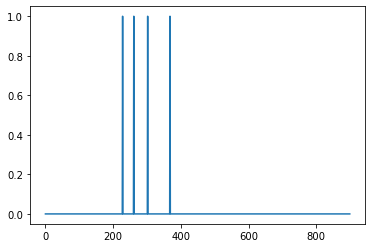

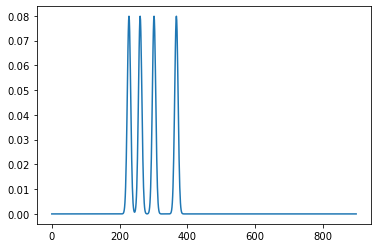

In [94]:

def get_data(dataset_name, phase='test', bin_size=5):
    """Function that extracts and formats data for training model"""
    curr_path = os.getcwd()
    fpath = curr_path + '/datasets/000138/sub-Jenkins/'
    dataset = NWBDataset(fpath, 
        skip_fields=['cursor_pos', 'eye_pos', 'cursor_vel', 'eye_vel', 'hand_pos'])
    dataset.resample(1)
    train_split = ['train', 'val'] if phase == 'test' else 'train'
    eval_split = phase
    train_dict = make_train_input_tensors(dataset, dataset_name, train_split, save_file=False, include_forward_pred=True)
    eval_dict = make_eval_input_tensors(dataset, dataset_name, eval_split, save_file=False)
    training_input = np.concatenate([
        train_dict['train_spikes_heldin'],
        np.zeros(train_dict['train_spikes_heldin_forward'].shape),
    ], axis=1)
    training_output = np.concatenate([
        np.concatenate([
            train_dict['train_spikes_heldin'],
            train_dict['train_spikes_heldin_forward'],
        ], axis=1),
        np.concatenate([
            train_dict['train_spikes_heldout'],
            train_dict['train_spikes_heldout_forward'],
        ], axis=1),
    ], axis=2)
    eval_input = np.concatenate([
        eval_dict['eval_spikes_heldin'],
        np.zeros((
            eval_dict['eval_spikes_heldin'].shape[0],
            train_dict['train_spikes_heldin_forward'].shape[1],
            eval_dict['eval_spikes_heldin'].shape[2]
        )),
    ], axis=1)
    del dataset
    return training_input, training_output, eval_input

        
# Run parameters
dataset_name = 'mc_maze_large'
phase = 'val'
bin_size = 5

# Extract data
training_input, training_output, eval_input = get_data(dataset_name, phase, bin_size)
# smoothen the spike data using gaussian filter of 5ms standaed deviation
std_gaus = 5
training_input_filt = scipy.ndimage.gaussian_filter1d(training_input, std_gaus, axis=1)
training_output_filt = scipy.ndimage.gaussian_filter1d(np.float64(training_output), std_gaus, axis=1)
eval_input_filt = scipy.ndimage.gaussian_filter1d(eval_input, std_gaus, axis=1)

plt.figure()
plt.plot(training_input[1,:,0])

plt.figure()
plt.plot(training_input_filt[1,:,0])

# Downsample all of the train and eval data to 5ms step size
bin_size = 5
resamp_int = np.arange(0, training_input_filt.shape[1], bin_size)
training_input_filt = training_input_filt[:, resamp_int, :]
training_output_filt = training_output_filt[:, resamp_int, :]
eval_input_filt = eval_input_filt[:, resamp_int, :]
#print(training_input.shape)
#resamp_interval = np.arange(0, training_input.shape[1], 5)
#print(training_input[:, resamp_interval,:].shape)

In [96]:

print(training_input_filt.shape)
print(training_output_filt.shape)
print(eval_input_filt.shape)



(375, 180, 122)
(375, 180, 162)
(125, 180, 122)


In [22]:
import torch
import numpy as np

class NLBRNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(NLBRNN, self).__init__()
        self.dropout1 = torch.nn.Dropout(p=dropout)
        self.rnn = torch.nn.GRU(input_size=input_dim,
                                hidden_size=hidden_dim,
                                num_layers=num_layers,
                                batch_first=True,
                                dropout=(dropout if num_layers > 1 else 0.),
                                bidirectional=False,
                                **factory_kwargs)
        self.dropout2 = torch.nn.Dropout(p=dropout)
        self.transform = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, X):
        output, hidden = self.rnn(self.dropout1(X))
        output = self.transform(self.dropout2(output))
        return torch.exp(output)

### 3.2 Input formatting


<center> <img src="https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/img/rnn_training_diagram.png?raw=true" width="800" /> </center>

We will next prepare our input and target data for training and evaluating the RNN. As seen in the figure above, we want the model to take held-in activity as input and predict firing rates for not only that held-in activity, but also held-out activity and future timesteps.

Our input data will then only have held-in channels, and future timesteps will be filled with zeros to run the RNN forward with no inputs for forecasting. Our true output data will have held-in, held-out, and future activity to compute loss.

In [24]:
training_input = torch.Tensor(
    np.concatenate([
        train_dict['train_spikes_heldin'], 
        np.zeros(train_dict['train_spikes_heldin_forward'].shape), # zeroed inputs for forecasting
    ], axis=1))

training_output = torch.Tensor(
    np.concatenate([
        np.concatenate([
            train_dict['train_spikes_heldin'],
            train_dict['train_spikes_heldin_forward'],
        ], axis=1),
        np.concatenate([
            train_dict['train_spikes_heldout'],
            train_dict['train_spikes_heldout_forward'],
        ], axis=1),
    ], axis=2))

We'll prepare the input for the final evaluation just like the training input.

In [25]:
eval_input = torch.Tensor(
    np.concatenate([
        eval_dict['eval_spikes_heldin'],
        np.zeros((
            eval_dict['eval_spikes_heldin'].shape[0],
            train_dict['train_spikes_heldin_forward'].shape[1],
            eval_dict['eval_spikes_heldin'].shape[2]
        )),
    ], axis=1))

### 3.3 Model Training

As mentioned above, the training script we used is available [here](https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/train.py). We essentially follow the diagram above but use an additional regularization scheme called coordinated dropout.

Instead of training the model though, we'll load a pre-trained RNN.

In [ ]:
# To download pre-trained model in Colab
!wget -O pretrained_rnn.ckpt https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/pretrained_rnn.ckpt?raw=true

In [26]:
model = NLBRNN(input_dim=training_input.shape[2], hidden_dim=40, output_dim=training_output.shape[2])
ckpt = torch.load('pretrained_rnn.ckpt')
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

### 3.4 Model Inference

<center> <img src="https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/img/tutorial_diagram_main_inference.png?raw=true" width="480" /> </center>

Finally, we'll generate our training and evaluation predictions by passing the data through the model.

In [28]:
model.eval()
training_predictions = model(training_input).cpu().detach().numpy()
eval_predictions = model(eval_input).cpu().detach().numpy()

## 4 Submission

<center> <img src="https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/img/tutorial_diagram_main_submission.png?raw=true" width="480" /> </center>

### 4.1 File Preparation

Now that we have predictions for the training and evaluation data, we can prepare a submission. The submission has a similar format to the returned data tensor dictionaries, but with an additional layer specifying the dataset.

The dataset name and array names must be correct in order for the automated evaluation to work properly, as shown below. `'eval_rates_heldin_forward'` and `'eval_rates_heldout_forward'` are required only if you would like results on the optional forward prediction metric.

In [30]:
tlen = train_dict['train_spikes_heldin'].shape[1]
num_heldin = train_dict['train_spikes_heldin'].shape[2]

submission = {
    'mc_maze_large': {
        'train_rates_heldin': training_predictions[:, :tlen, :num_heldin],
        'train_rates_heldout': training_predictions[:, :tlen, num_heldin:],
        'eval_rates_heldin': eval_predictions[:, :tlen, :num_heldin],
        'eval_rates_heldout': eval_predictions[:, :tlen, num_heldin:],
        'eval_rates_heldin_forward': eval_predictions[:, tlen:, :num_heldin],
        'eval_rates_heldout_forward': eval_predictions[:, tlen:, num_heldin:]
    }
}

These dicts must be in an HDF5 format to be submitted to EvalAI. We have a function called `save_to_h5` to save these dictionaries to HDF5 files while preserving the structure.

In [31]:
# from nlb_tools.make_tensors import save_to_h5

# save_to_h5(submission, 'submission.h5')

### 4.2 Submission Upload

The files can be submitted through the EvalAI website or using their CLI tool. The CLI tool is recommended for large files (>300 MB), but there is no difference for smaller files.

In [32]:
# Configure EvalAI-CLI with your account credentials
# !evalai set_token <auth_token>

# Our challenge's id is 1256, and the phase ids are 2539 for Validation and 2540 for Test
# So, to submit to the Validation phase of NLB'21:
# !evalai challenge 1256 phase 2539 submit --file submission.h5

# and if the file is large:
# !evalai challenge 1256 phase 2539 submit --file submission.h5 --large

See [this page](https://cli.eval.ai/) for more info on the EvalAI-CLI tool.

Once your file is submitted, you can log in to EvalAI, go to our [challenge](https://eval.ai/web/challenges/challenge-page/1256/overview), and view the evaluation results in the 'My Submissions' tab. If your submission errored in evaluation, you can see the error output to assist in debugging.

## 5 Local Evaluation

<center> <img src="https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/img/tutorial_diagram_main_evaluation.png?raw=true" width="600" /> </center>


For the Test Phase, submissions must be uploaded to EvalAI for evaluation. For the Validation Phase, submissions can also be evaluated locally with provided data and functions.

First, we prepare the data used for evaluation with `make_eval_target_tensors`. This function extracts all necessary evaluation data from the loaded dataset.

In [33]:
from nlb_tools.make_tensors import make_eval_target_tensors

target_dict = make_eval_target_tensors(dataset=dataset, 
                                       dataset_name='mc_maze_large',
                                       train_trial_split='train',
                                       eval_trial_split='val',
                                       include_psth=True,
                                       save_file=False)

Then, we can evaluate with the `evaluate` function. Every submission is scored on a number of metrics, each evaluating different aspects of the model output.

In [34]:
from nlb_tools.evaluation import evaluate

evaluate(target_dict, submission)

[{'mc_maze_scaling_split': {'[500] co-bps': 0.3211858864626676,
   '[500] vel R2': 0.856816843986107,
   '[500] psth R2': 0.5743404432814287,
   '[500] fp-bps': 0.18072337679652054}}]

## 6 Conclusion

This tutorial gave an overview of the NLB'21 pipeline from loading raw data to submission and demonstrated how to make use of our provided code package, `nlb_tools`, to participate in NLB'21.

For additional helpful resources, we have a number of other tutorials and example scripts covering a variety of topics:
* The notebooks in the [`nlb_tools` repo](https://github.com/neurallatents/nlb_tools) demonstrate application of classical methods like spike smoothing, GPFA, and SLDS to NLB'21.
* Andrew Sedler's [nlb-lightning](https://github.com/arsedler9/nlb-lightning) package provides a convenient framework to develop and evaluate PyTorch Lightning models for NLB'21.